In [1]:
import numpy as np 
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [2]:
data_dir = '/home/braunger/masterthesis/data/'
save_dir = '/home/braunger/masterthesis/save/'
las_dir = '/home/braunger/rejuvenation_project/data/processed_hic_data/'

# A: All interchromosomal LAS submatrices per replicate

In [3]:
input_dir = las_dir + 'Young_B1R1/LAS-20/'
output_dir = save_dir + 'processed_hic_data/APA/all_LAS_per_replicate/'

chromosomes = [i for i in range(1, 23, 1)]
chr_pairs = list(itertools.combinations(chromosomes, 2))
results = pd.DataFrame()

for pair in chr_pairs:
    chr1, chr2 = pair
    LAS = pd.read_csv(input_dir+'intermingling_regions.chr' + str(chr1) + '_chr' + str(chr2) + '.avg_filt.csv')
    LAS['start col'] = [str(int(loc)) for loc in LAS['start col']]
    LAS['stop col'] = [str(int(loc)) for loc in LAS['stop col']]
    LAS['start row'] = [str(int(loc)) for loc in LAS['start row']]
    LAS['stop row'] = [str(int(loc)) for loc in LAS['stop row']]
    LAS_chr_pair = pd.DataFrame({'#chr1': str(chr1), 'start1': LAS['start row'], 'end1': LAS['stop row'],
                                'chr2': str(chr2), 'start2': LAS['start col'], 'end2': LAS['stop col']})
    results = pd.concat([results, LAS_chr_pair])

results.to_csv(output_dir + 'Young_B1R1_inter.txt', sep='\t', index=False)

juicer tools.jar apa was used with the following settings for each Hi-C replicate and the corresponding PeaksFiles created in this notebook: -r 250000 -k INTER_SCALE -w 50 -q 10 --include-inter-chr

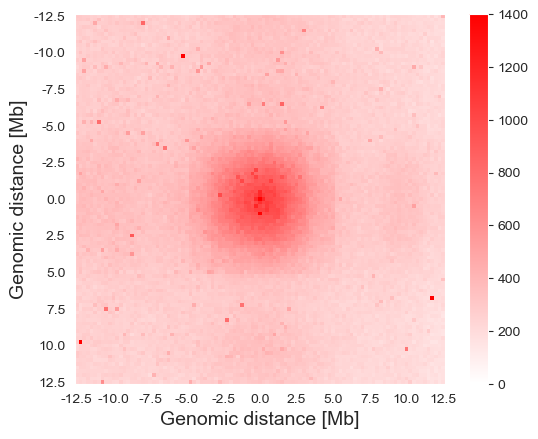

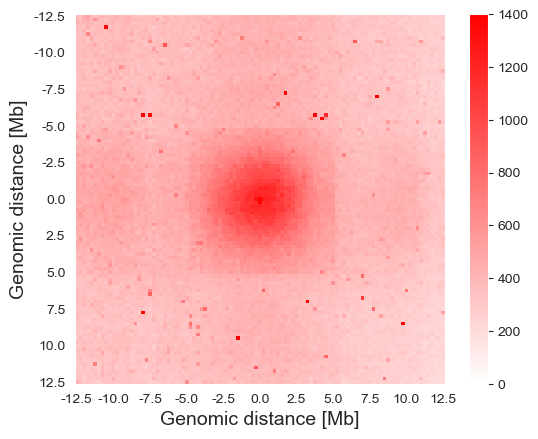

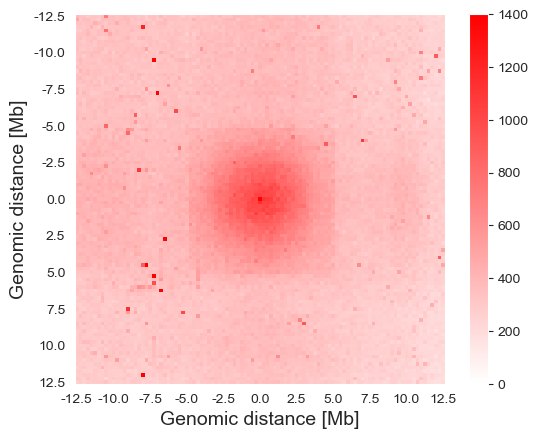

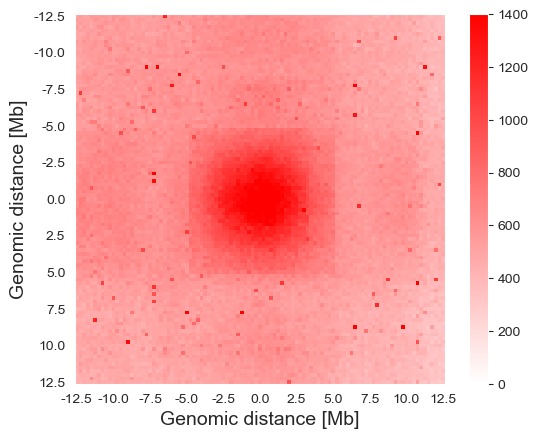

In [4]:
# Plotting the results
def plot_APA(sample): 
    with open (output_dir + sample + '_inter/250000/gw/APA.txt', 'r') as file:
        data = [line.strip()[1:-1] for line in file]

    data = pd.DataFrame([line.split(', ') for line in data])
    data = data.apply(pd.to_numeric, errors = 'coerce')
    
    data.columns = [i * 250 / 1000 for i in range(-50, 51, 1)]
    data.index = [i * 250 / 1000 for i in range(-50, 51, 1)]
    
    plt.rc('font', family='serif')
    sns.set_style("dark", {'axes.grid':False})
    numclust = 50
    custom_cmap = LinearSegmentedColormap.from_list('custom', [(1, 1, 1), (1, 0, 0)], N = 256)

    plt.figure()
    plt.imshow(data, cmap = custom_cmap, vmin = 0, vmax = 1400) 
    plt.xticks(range(0, len(data.columns), 10), data.columns[0::10])
    plt.yticks(range(0, len(data.columns), 10), data.columns[0::10])
    
    cbar = plt.colorbar()

    plt.xlabel('Genomic distance [Mb]', fontsize = 14)
    plt.ylabel('Genomic distance [Mb]', fontsize = 14)
    plt.savefig(output_dir + sample + '_inter/250000/gw/APA.png', dpi = 500, bbox_inches="tight")
    

plot_APA('Young_B1R1')
plot_APA('Young_B1R2')
plot_APA('Old_B1R1')
plot_APA('Old_B2R2')

# B: Specific intermingling of signature DE genes

In [5]:
def get_diff_map_long_APA(diff_map, group, im_type, data_dir, save_dir):
    # load DE genes
    DE_genes = pd.read_csv(data_dir+'de_data/DE_' + group + '.csv')

    # load loci of all DE targets
    all_gene_loci = pd.read_csv(data_dir+'genome_data/all_gene_loci.csv')
    DE_genes = DE_genes.merge(all_gene_loci, on = "gene")
    DE_genes = DE_genes[['gene', 'locus']]
    DE_genes = DE_genes.set_index('locus', drop = False)
    
    # create diff_map for DE targets
    diff_map_long = diff_map.copy()
    diff_map_long['loc1'] = diff_map_long.index
    diff_map_long = pd.melt(diff_map_long, id_vars = 'loc1', var_name = 'loc2')
    diff_map_long = diff_map_long[diff_map_long['loc1'].isin(DE_genes['locus']) & diff_map_long['loc2'].isin(DE_genes['locus'])]
    diff_map_long = DE_genes.rename(columns={"gene": "gene1", "locus": "loc1"}).merge(diff_map_long, on = 'loc1')
    diff_map_long = DE_genes.rename(columns={"gene": "gene2", "locus": "loc2"}).merge(diff_map_long, on = 'loc2')
    
    # filter for young- or old-specific intermingling
    diff_map_long = diff_map_long[diff_map_long['value'] == im_type]
    
    # split loci in chromosome name and position
    diff_map_long['#chr1'] = [loc.split('_')[1] for loc in diff_map_long['loc1']]
    diff_map_long['start1'] = [loc.split('_')[3] for loc in diff_map_long['loc1']]
    diff_map_long['end1'] = [loc.split('_')[3] for loc in diff_map_long['loc1']]    
    diff_map_long['chr2'] = [loc.split('_')[1] for loc in diff_map_long['loc2']]
    diff_map_long['start2'] = [loc.split('_')[3] for loc in diff_map_long['loc2']]
    diff_map_long['end2'] = [loc.split('_')[3] for loc in diff_map_long['loc2']]    
                              
    return diff_map_long[['#chr1', 'start1', 'end1', 'chr2', 'start2', 'end2']]

In [6]:
# Create difference map of young- and old-specific intermingling
young = pd.read_csv(save_dir + 'processed_hic_data/Young_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
old = pd.read_csv(save_dir + 'processed_hic_data/Old_combi/binarized_maps/all_gene_loci_subset.csv', index_col = 0)
diff_map = young + 2 * old #0: no intermingling, 1: young-specific, 2: old-specific, 3: shared intermingling

# Age group 1 upregulated genes with young-specific intermingling
g1_up_young = get_diff_map_long_APA(diff_map, 'Group1_up', 1, data_dir, save_dir)
g1_up_young.to_csv(save_dir + 'processed_hic_data/APA/g1_up_young.txt', sep='\t', index=False)

# Age group 1 downregulated genes with old-specific intermingling
g1_down_old = get_diff_map_long_APA(diff_map, 'Group1_down', 2, data_dir, save_dir)
g1_down_old.to_csv(save_dir + 'processed_hic_data/APA/G1_down/g1_down_old.txt', sep='\t', index=False)

# Age group 5 upregulated genes with old-specific intermingling
g5_up_old = get_diff_map_long_APA(diff_map, 'Group5_up', 2, data_dir, save_dir)
g5_up_old.to_csv(save_dir + 'processed_hic_data/APA/G5_up/g5_up_old.txt', sep='\t', index=False)

# Age group 5 downregulated genes with young-specific intermingling
g5_down_young = get_diff_map_long_APA(diff_map, 'Group5_down', 1, data_dir, save_dir)
g5_down_young.to_csv(save_dir + 'processed_hic_data/APA/G5_down/g5_down_young.txt', sep='\t', index=False)

juicer tools.jar apa was used with the following settings for each Hi-C replicate and the PeaksFiles created in this notebook: -r 250000 -k INTER_SCALE -w 50 -q 10 --include-inter-chr

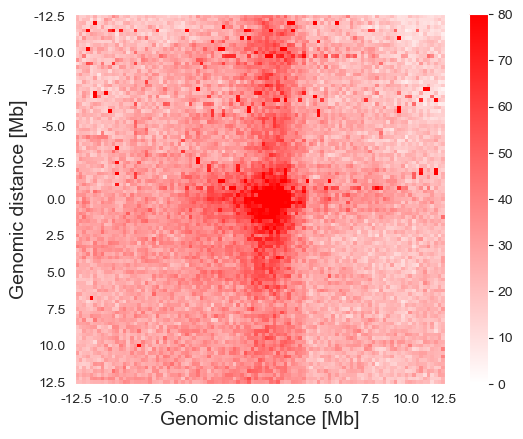

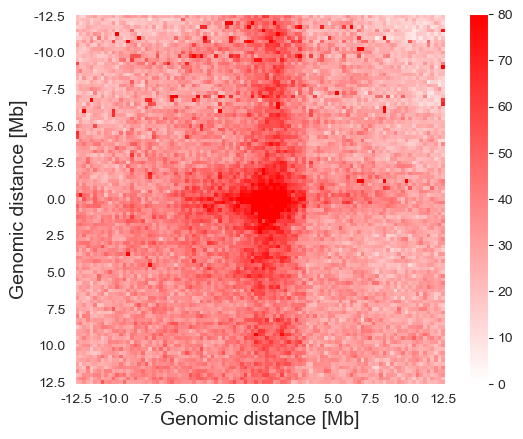

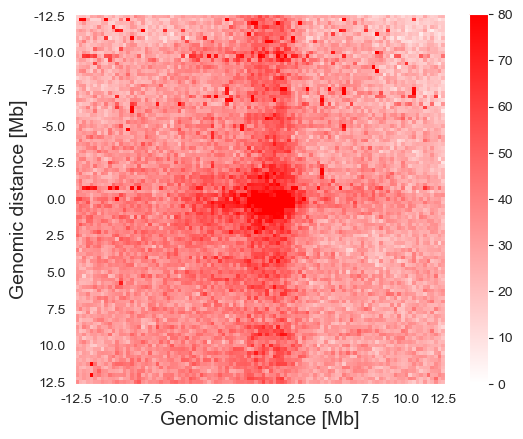

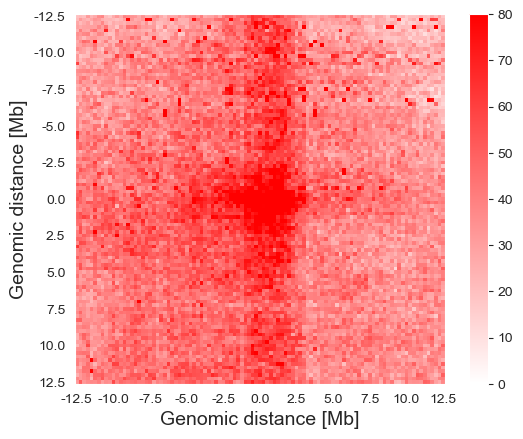

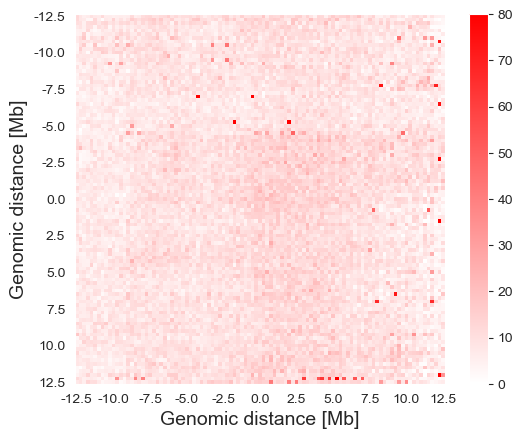

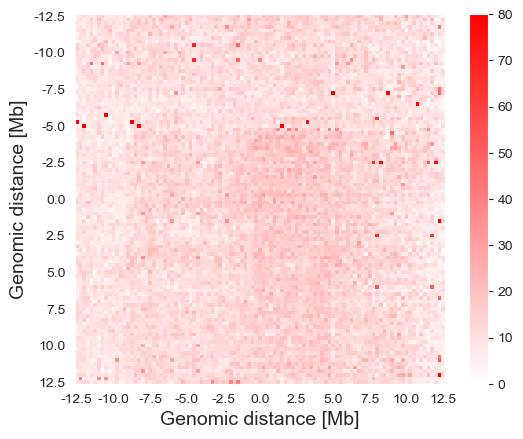

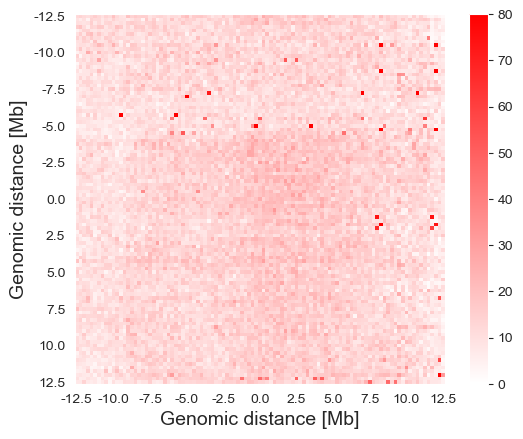

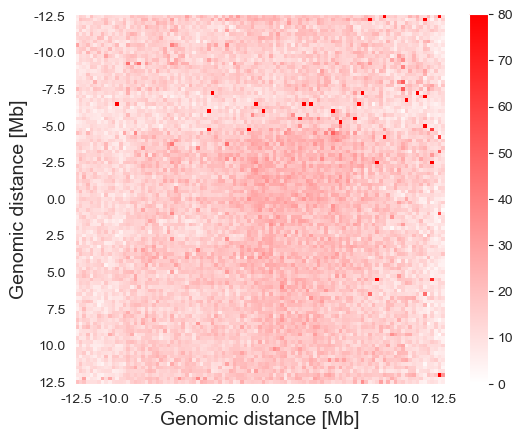

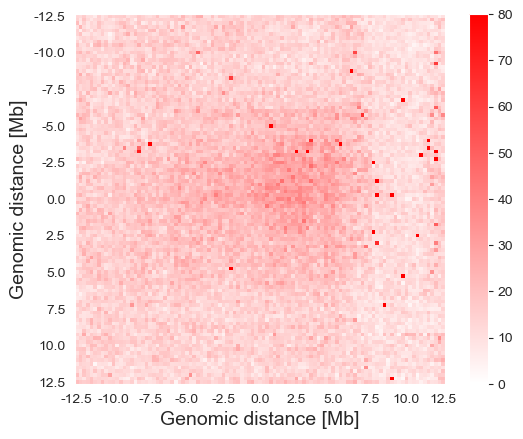

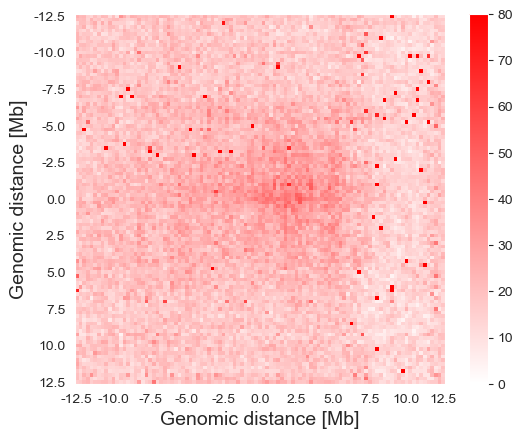

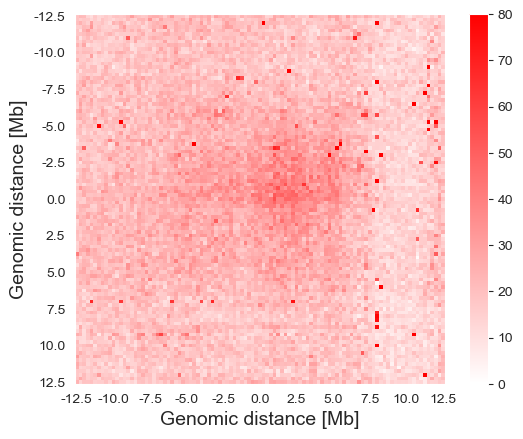

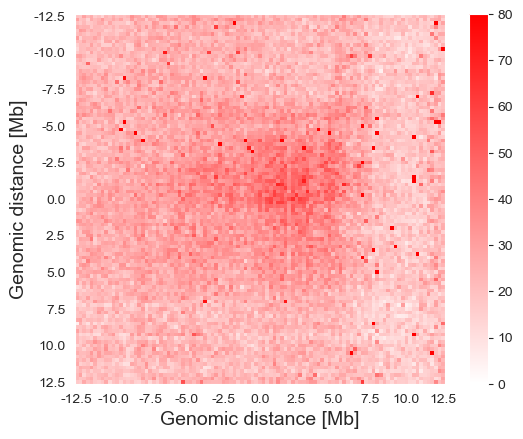

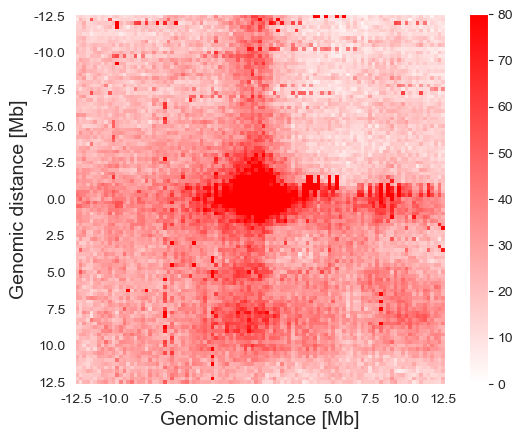

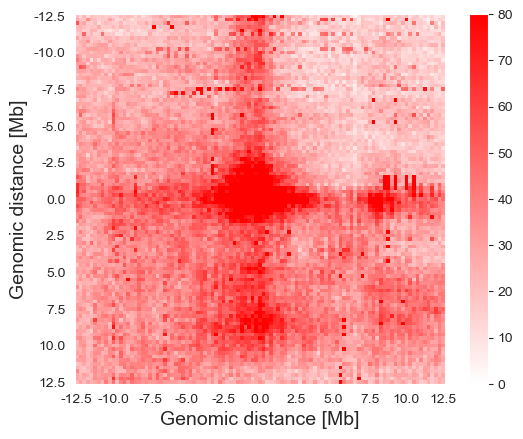

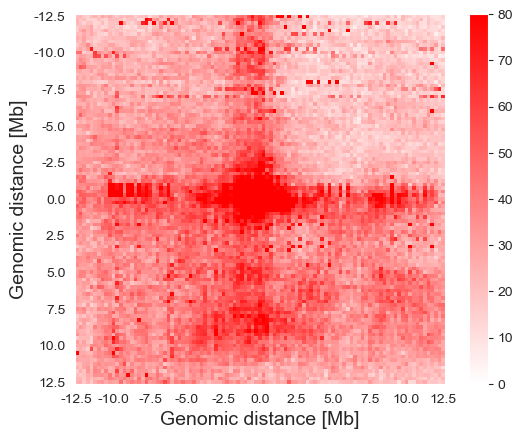

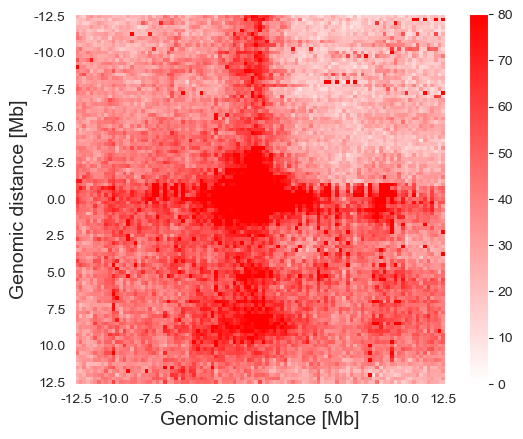

In [7]:
# Plotting the results
output_dir = save_dir + 'processed_hic_data/APA/'
def plot_APA(group, sample, im_type): 
    with open (output_dir + group + '/' + sample + '_' + im_type + '/250000/gw/APA.txt', 'r') as file:
        data = [line.strip()[1:-1] for line in file]

    data = pd.DataFrame([line.split(', ') for line in data])
    data = data.apply(pd.to_numeric, errors = 'coerce')
    
    data.columns = [i * 250 / 1000 for i in range(-50, 51, 1)]
    data.index = [i * 250 / 1000 for i in range(-50, 51, 1)]
    
    plt.rc('font', family='serif')
    sns.set_style("dark", {'axes.grid':False})
    numclust = 50
    custom_cmap = LinearSegmentedColormap.from_list('custom', [(1, 1, 1), (1, 0, 0)], N = 256)

    plt.figure()
    plt.imshow(data, cmap = custom_cmap, vmin = 0, vmax = 80) 
    plt.xticks(range(0, len(data.columns), 10), data.columns[0::10])
    plt.yticks(range(0, len(data.columns), 10), data.columns[0::10])
    
    cbar = plt.colorbar()

    plt.xlabel('Genomic distance [Mb]', fontsize = 14)
    plt.ylabel('Genomic distance [Mb]', fontsize = 14)
    plt.savefig(output_dir + group + '/' + sample + '_' + im_type + '/APA.png', dpi = 500, bbox_inches="tight")
    
# Group 1 up
plot_APA('G1_up', 'Young_B1R1', 'young-im')
plot_APA('G1_up', 'Young_B1R2', 'young-im')
plot_APA('G1_up', 'Old_B1R1', 'young-im')
plot_APA('G1_up', 'Old_B2R2', 'young-im')

# Group 1 down
plot_APA('G1_down', 'Young_B1R1', 'old-im')
plot_APA('G1_down', 'Young_B1R2', 'old-im')
plot_APA('G1_down', 'Old_B1R1', 'old-im')
plot_APA('G1_down', 'Old_B2R2', 'old-im')

# Group 5 up
plot_APA('G5_up', 'Young_B1R1', 'old-im')
plot_APA('G5_up', 'Young_B1R2', 'old-im')
plot_APA('G5_up', 'Old_B1R1', 'old-im')
plot_APA('G5_up', 'Old_B2R2', 'old-im')

# Group 5 down
plot_APA('G5_down', 'Young_B1R1', 'young-im')
plot_APA('G5_down', 'Young_B1R2', 'young-im')
plot_APA('G5_down', 'Old_B1R1', 'young-im')
plot_APA('G5_down', 'Old_B2R2', 'young-im')